In [3]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import os
import math

class ImagePipeLine:
    def __init__(self, x_max, y_max):
        self.img = None
        self.x_max = x_max
        self.y_max = y_max        
        self.prev_left_line = []
        self.prev_right_line = []
    
    def load(self, image):
        self.img = image
        return self

    def grayscale(self):
        """Applies the Grayscale transform
        This will return an image with only one color channel
        but NOTE: to see the returned image as grayscale
        you should call plt.imshow(gray, cmap='gray')"""
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        return self

    def canny(self, low_threshold, high_threshold):
        """Applies the Canny transform"""
        self.img = cv2.Canny(self.img, low_threshold, high_threshold)
        return self

    def gaussian_blur(self, kernel_size):
        """Applies a Gaussian Noise kernel"""
        self.img = cv2.GaussianBlur(self.img, (kernel_size, kernel_size), 0)
        return self

    def region_of_interest(self, vertices):
        """
        Applies an image mask.

        Only keeps the region of the image defined by the polygon
        formed from `vertices`. The rest of the image is set to black.
        """
        #defining a blank mask to start with
        mask = np.zeros_like(self.img)   

        #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
        if len(self.img.shape) > 2:
            channel_count = self.img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        #filling pixels inside the polygon defined by "vertices" with the fill color    
        cv2.fillPoly(mask, vertices, ignore_mask_color)

        #returning the image only where mask pixels are nonzero
        masked_image = cv2.bitwise_and(self.img, mask)
        self.img = masked_image
        return self

    def hough_lines(self, rho, theta, threshold, min_line_len, max_line_gap):
        """
        `img` should be the output of a Canny transform.

        Returns an image with hough lines drawn.
        """
        lines = cv2.HoughLinesP(self.img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        self.img = np.zeros(self.img.shape, dtype=np.uint8)
        new_lines = self.__filter_lines(lines)
        ans = [[], []]
        ans[0] = [new_lines[0]]
        ans[1] = [new_lines[1]]
        if len(ans) > 0:
            self.__draw_lines(ans, thickness=9)
        return self

    def __filter_lines(self, lines):
        line_with_slope = [( line[0], ((line[0][1]-line[0][3])/(line[0][0]-line[0][2])) ) for line in lines]  
        right = [line for line,slope in line_with_slope if slope > 0 and abs(slope) > 0.5 ]
        left = [line for line,slope in line_with_slope if slope < 0 and abs(slope) > 0.5 ]
    
        
        left_line = self.average_lines(left)
        right_line = self.average_lines(right)
        
        if len(left_line) > 0:            
            left_line = self.extrapolate_line(left_line)
            self.prev_left_line = left_line
        else:
            left_line = self.prev_left_line

        if len(right_line) > 0:            
            right_line = self.extrapolate_line(right_line)
            self.prev_right_line = right_line
        else:
            right_line = self.prev_right_line
        
        return [left_line, right_line]
    
    
    def extrapolate_line(self, line):
        x1,y1,x2,y2 = line
        a = np.array([[x1,1], [x2 ,1]])
        b = np.array([y1,y2])
        m,c = np.linalg.solve(a, b)
        
        #bottom
        y2 = self.y_max
        x2 = int((y2 - c)/m)
        
        #top
        y1 = int(0.6*self.y_max)
        x1 = int((y1 - c)/m)
        
        return [x1, y1, x2, y2]
        

    def average_lines(self, lines):
        top = []
        bottom = []
        for x1,y1,x2,y2 in lines:
            #x1,y1,x2,y2
            if y1 < y2:
                top.append([x1, y1])
                bottom.append([x2, y2])
            else:
                top.append([x2, y2])
                bottom.append([x1, y1])                

        if len(top) > 0:
            avg_top = [ int(np.average([point[0] for point in top])), int(np.average([point[1] for point in top]))]
        else:
            avg_top = []
        
        if len(bottom) > 0:
            avg_bottom = [ int(np.average([point[0] for point in bottom])), int(np.average([point[1] for point in bottom]))]
        else:
            avg_bottom = []
        
        
        return avg_top + avg_bottom
            
            

    # Python 3 has support for cool math symbols.

    def weighted_img(self, initial_img, α=0.8, β=1., λ=0.):
        """
        `img` is the output of the hough_lines(), An image with lines drawn on it.
        Should be a blank image (all black) with lines drawn on it.

        `initial_img` should be the image before any processing.

        The result image is computed as follows:

        initial_img * α + img * β + λ
        NOTE: initial_img and img must be the same shape!
        """
        self.img = cv2.addWeighted(initial_img, α, self.img, β, λ)
        return self
    
    def __draw_lines(self, lines, color=[255, 0, 0], thickness=2):
        """
        NOTE: this is the function you might want to use as a starting point once you want to 
        average/extrapolate the line segments you detect to map out the full
        extent of the lane (going from the result shown in raw-lines-example.mp4
        to that shown in P1_example.mp4).  

        Think about things like separating line segments by their 
        slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
        line vs. the right line.  Then, you can average the position of each of 
        the lines and extrapolate to the top and bottom of the lane.

        This function draws `lines` with `color` and `thickness`.    
        Lines are drawn on the image inplace (mutates the image).
        If you want to make the lines semi-transparent, think about combining
        this function with the weighted_img() function below
        """
        
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(self.img, (x1, y1), (x2, y2), color, thickness)
    
    def gray2rgb(self):
        self.img = cv2.cvtColor(self.img, cv2.COLOR_GRAY2RGB)
        return self
    
    
    def rgb_lower_bound(self, red, blue, green, target):
        thresholds = (self.img[:,:,0] > red) | (self.img[:,:,1] > blue) | (self.img[:,:,2] > green)
        self.img[thresholds] = target
        return self
                
    def build(self):
        return self.img
                
    def plot(self, cmap=None):
        plt.imshow(self.img, cmap=cmap)


def process_image(image):
    p = ImagePipeLine(image.shape[1], image.shape[0])
    
    return p.load(image)\
    .grayscale()\
    .gaussian_blur(kernel_size=5)\
    .canny(90, 180)\
    .region_of_interest([np.array([[180, 500], [900, 500], [500, 280]])]) \
    .hough_lines(theta=0.07, rho=0.8, min_line_len=130, max_line_gap=290, threshold=22)\
    .gray2rgb() \
    .rgb_lower_bound(230, 230, 230, [255, 0, 0]) \
    .weighted_img(initial_img=image) \
    .build()
    

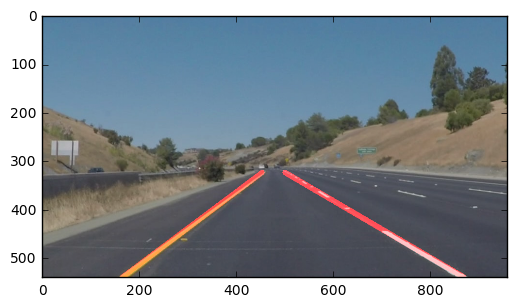

In [4]:

img = process_image(mpimg.imread("test_images/solidYellowCurve2.jpg"))
plt.imshow(img, cmap='gray')


In [7]:
directory = "test_images/"

for file in os.listdir(directory):
    image = mpimg.imread(directory + file)
    final = process_image(image)
    cv2.imwrite(directory + file+"_output"+".png", final)


In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)


[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:21<00:00, 39.49it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 11.9 s, sys: 1.83 s, total: 13.7 s
Wall time: 22.5 s


In [10]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML


yellow_output = 'white.mp4'
clip2 = VideoFileClip('solidWhiteRight.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:12<00:00, 13.72it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 5.53 s, sys: 1.45 s, total: 6.98 s
Wall time: 15.1 s


In [11]:
def process_larger(image):
    return p.load(image)\
    .grayscale()\
    .gaussian_blur(kernel_size=5)\
    .canny(90, 180)\
    .region_of_interest([np.array([[100, 700], [1200, 700], [650, 350]])]) \
    .hough_lines(theta=0.07, rho=0.8, min_line_len=130, max_line_gap=290, threshold=22)\
    .gray2rgb() \
    .rgb_lower_bound(230, 230, 230, [255, 0, 0]) \
    .weighted_img(initial_img=image) \
    .build()
    
p = ImagePipeLine(1280, 720)
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_larger)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:36<00:00,  8.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 15.7 s, sys: 3.94 s, total: 19.7 s
Wall time: 40.2 s


# Reflection


The project was identifying lane markings on the road using frames in a video. So the assumption is that there are lane markings on the road and I will write the reflection based on this assumption. And also the primary purpose of lane lines is to give a sense of direction for the vehicle.
    
    * The current algorithm relies on canny and hough to identify to find the lanes on the road. The canny edge detection algorithm uses pixel density derivatives to identifty "edges". This is good for roads as lane marking are usually distinctly different in color than the road. 
    
    * In addition to the steps outlined in the notebook - I also had to add a few things to make the algorithm more robust. The lines given by the hough transform are not always the what is required. So some filtering of the lines produced by hough needs to be done. One such filtering I added was to only have lines that had slope > 0.5. This makes sure we can weed out horizontal which cannot be lane markings. With proper tuning I believe one can get the best set of lines - but then this becomes very tedious when it has to be applied to different driving scenarios. 
    
    * In an uninteresting road the lane markings may the only ones having a distinct pixel density. But in other roads there maybe object and other buildings that can cause stark differences in pixel density causing canny to output those edges as well. To address this we can only choose edges which go from gray/black/ash to yellow/white. Majority of the roads in the US and elsewhere in the world are black//gray. This preprocessing will also help identify edges that are only on the road.
    
    * Sometimes natural elements like sunlight, mirages, shadows, overcast skies etc can bleach the road and lane markings. In such cases the canny edge detector does not identify these edges at all and the hough transform does not have lines to work with. In my implementation I cache the value from the previous frame and use it if the canny edge is not able to detect edges. This can work sometimes - recall that when we humans drive we do something similar (we also slow down). Also if we have additional data like - road signs we can use that information guess the orientation/direction of the road and plot an approximate lane. Another great signal would be to use GPS to know how the road is turning. 
    
    * If one the lanes is visible better than the other then we can draw another line, so that along with the apex an isoceles traingle is made by the lane lines and the frame. This ofcourse assumes that the car is in the middle of the lane which is a reasonable assumption to make. 
    